# Lab 2 Take Home Experiment Report

**Author:** Alejandro Alfaro

## Environment Setup
Code in this section help you setup the environment for the subsequent data analysis and visualization. Follow the steps below to perform a one-time setup of your envionrment. This ensures that the visualization code runs without error so make sure you follow these steps **before proceding to the next section**.

1. Run the next cell to make sure your `matplotlib` is up-to-date.
2. Go to `Kernel -> Restart` in the top menu to restart your kernel.
3. To test that everything is working properly, do `Cell -> Run All` and confirm that the bar chart of the fake data in this template is showing up. Note that some of you might get a message like `Matplotlib is building the font cache ...` while importing the matplotlib library in the next section. This is normal and will take some time to finish. Just be patient.
4. After confirming that the dummy bar chart is showing up, everything is working and you can proceed to the next section. 

If you are still unable to setup `matplotlib` after followed all the steps, please report your error to Yellowdig and we will help you debug.

In [40]:
# After the one-time setup is complete, and the example bar chart shows up at 
# the end of this notebook, you can comment these lines out
!pip install -U pip
!pip install -U matplotlib

Requirement already up-to-date: pip in /anaconda3/lib/python3.6/site-packages (18.1)
Requirement already up-to-date: matplotlib in /anaconda3/lib/python3.6/site-packages (3.0.0)


## Load Libraries and Define Helper Functions (make sure your environment is setup)

In [41]:
# import mean and stdev
from statistics import mean, stdev

# import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
'''Helper functions to make your life easier

The following functions provides functions that could be useful for you to
properly process your data. Use them based on your need.
'''

# Function to unpack measurement file
def unpack_data(filename='inclined.txt'):
    '''unpack_data unpacks measurements and output each column
    
    INPUT:
        filename (str): path to data file to unpack
        
    OUTPUT:
        tuple of all unpacked columns as lists
        
    EXAMPLE:
        time_list, temp_list = unpack_data(filename='temperature.txt')             # data file with 2 columns
        time_list, xaxis, yaxis, zaxis = unpack_data(filename='accelerometer.txt') # data file with 4 columns
    '''
    # read file and convert units
    with open(filename, 'r') as file:
        temps = file.read()
    measurements = [m.split(',') for m in temps.split('\n') if len(m) > 2]
    # unpack values and assemble a tuple for output
    # note that the following code assumes you have followed the guideline to put
    # time as the first value in the measurement list
    #
    # process time column
    time_list = [float(m[0]) for m in measurements]
    # Remove initial time offset to make time starts from 0
    time_list = [val-time_list[0] for val in time_list]
    # loop through all remaining columns
    out_tuple = (time_list,)
    for idx in range(1, len(measurements[0])):
        data_list = [float(m[idx]) for m in measurements]
        out_tuple += (data_list,)
    return out_tuple

# Helper function to recursively convert the data from string to out_type
# which by default is float
# This function works for lists of any arbitrary dimension
def recursive_list_convert(ls, out_type=float):
    '''unpack_data unpacks measurements and output each column
    
    INPUT:
        ls (list): input list to convert
        out_type (type or function, optional): type to convert all list elements to, e.g. float
                                               you can even use function for customized data 
                                               processing
        
    OUTPUT:
        list with all element converted with out_type
        
    EXAMPLE:
        recursive_list_convert(['1',2,['3',['4',5]]]) # return [1.0, 2.0, [3.0, [4.0, 5.0]]]
    '''
    if type(ls) is not list: return out_type(ls)
    if len(ls) is 0: return []
    if len(ls) > 0:
        ret = []
        for lls in ls: ret.append(recursive_list_convert(lls))
        return ret
    else: return out_type(ls)

# Helper function to estimate actual sampling dt
def estimate_dt(time_ls):
    '''estimate_dt estimates actual dt measured in data file
    
    INPUT:
        time_ls (list): list containing measured time samples
        
    OUTPUT:
        estimated dt (float)
        
    EXAMPLE:
        dt = estimate_dt(time_list)
    '''
    cum_dt = 0
    for t in range(1, len(time_ls)):
        cum_dt += time_ls[t] - time_ls[t-1]
    return cum_dt / (len(time_ls)-1)

# Helper function for computing Root mean squared error (RMSE)
def rmse(x, u=0):
    '''estimate_dt estimates actual dt measured in data file
    
    INPUT:
        x (list): list of numbers
        u (number, optional): mean to compare against, default is zero 
        
    OUTPUT:
        rmse error (float)
        
    EXAMPLE:
        rmse_val = rmse(value_list)
    '''
    mse = 0
    for i in range(len(x)):
        mse += (x[i] - u)**2
    return (mse / len(x))**0.5

## Experiment Setup
Include an image of your experiment setup here. `src="./setup.jpg"` specifies where your image is located and `style="width: 300px;"` sets the display size. Update the `width` if you image is too big/small. (To change a Markdown cell like this one, you just double click inside of it.)

<img src="./setup.jpg" style="width: 300px;"/>

## Data Processing
Process your data here. It involves a couple of different stages:

1. Load your data and check your format. The helper functions assume you have followed the exact formatting we asked you to implement during lab 2, which should be in `time, value1, value2, ...\n` format. You are welcome to write your own parser should you chose a different format.
2. Parse the input data fields into `list` to make them easier to process.
3. Process the data according to the requirements and prepare the result for visualizations in the next section.

Make sure you format and comment your code well. This is one important aspect that differentiates good and bad programmers. Python has its unique programming style, this include how comments should be formatted and placed to make you code truely _Pythonic_. The style is referred as **PEP 8** (which means it's the 8th document in the Python Enhancement Proposals index) and is summarized in **[this very short cheatsheet](https://gist.github.com/RichardBronosky/454964087739a449da04)**.

In [43]:
'''
Your code starts here, I have included an example below to give you a head start. 

Remove or modify the example code to start your own work.
''' 
import math

# Unpack input file and get measurements:
time_list, x_axis, y_axis, z_axis = unpack_data('flat.txt')
time_list1, x_axis1, y_axis1, z_axis1 = unpack_data('H=14.7cm.txt')
time_list2, x_axis2, y_axis2, z_axis2 = unpack_data('H=15cm.txt')
time_list3, x_axis3, y_axis3, z_axis3 = unpack_data('H=15.2cm.txt')
time_list4, x_axis4, y_axis4, z_axis4 = unpack_data('Offset.txt')
# Estimate dt and fs (sampling frequency)
dt = estimate_dt(time_list)
fs = 1 / dt
print(f'Actual sampling dt = {dt:.4f} s, fs = {fs:.4f} Hz, {len(time_list)} total samples')

#Convert measurements taken while the board was flat into floats:
flatt = recursive_list_convert(time_list, out_type=float)
flatx = recursive_list_convert(x_axis, out_type=float)
flaty = recursive_list_convert(y_axis, out_type=float)
flatz = recursive_list_convert(z_axis, out_type=float)

#Get the mean of the measurements of the x-axis and z-axis to get the baselines for the x-axis and z-axis measurements:
meanflatx = mean(flatx)
meanflatz = mean(flatz)

#Convert measurments into floats:
x1 = recursive_list_convert(x_axis1, out_type=float)
z1 = recursive_list_convert(z_axis1, out_type=float)

#Process the x-axis and z-axis measuremetns to calculate theta:

#theta is estimated using arctan of the x-axis measurment over the z-axis measurement
#The baseline was subtracted from the two measurements to make the results more accurate.
theta1 = []
for i in range(len(z1)):
    theta1.append(math.degrees(math.atan((x1[i]-meanflatx)/(z1[i]-meanflatz)))) 


#The mean is taken from the whole data set to get a value to compare with the trigonometrical value.
meantheta1 = mean(theta1)
stdvtheta1 = stdev(theta1)

#Repeat process with second data set
x2 = recursive_list_convert(x_axis2, out_type=float)
z2 = recursive_list_convert(z_axis2, out_type=float)

theta2 = []
for i in range(len(z2)):
    theta2.append(math.degrees(math.atan((x2[i]-meanflatx)/(z2[i]-meanflatz)))) 

meantheta2 = mean(theta2)
stdvtheta2 = stdev(theta2)

#Repeat process with third data set
x3 = recursive_list_convert(x_axis3, out_type=float)
z3 = recursive_list_convert(z_axis3, out_type=float)

theta3 = []
for i in range(len(z3)):
    theta3.append(math.degrees(math.atan((x3[i]-meanflatx)/(z3[i]-meanflatz)))) 

meantheta3 = mean(theta3)
stdvtheta3 = stdev(theta3)

#Trigonometry method of getting theta1:
b = 16.5
h1 = 14.7
thetatrig1 = math.degrees(math.asin(h1/b))

#Trigonometry method of getting theta2:
h2 = 15
thetatrig2 = math.degrees(math.asin(h2/b))

#Trigonometry method of getting theta3:
h3 = 15.2
thetatrig3 = math.degrees(math.asin(h3/b))


#Convert offset measurments into floats:
Offsett = recursive_list_convert(time_list4, out_type=float)
Offsetx = recursive_list_convert(x_axis4, out_type=float)
Offsety = recursive_list_convert(y_axis4, out_type=float)
Offsetz = recursive_list_convert(z_axis4, out_type=float)

#The measurements for the the offset angle measurements were calculated the same way as previously done with the original ones.
thetaO = []
for i in range(len(Offsetz)):
    thetaO.append(math.degrees(math.atan((Offsetx[i]-meanflatx)/(Offsetz[i]-meanflatz)))) 
    
 
    
#Section to calculate the angle resolution. The mean angle of the second measurements was subtracted from the originall
#measurements. 
angresolution= []
for i in range(len(theta1)):
     angresolution.append(abs(theta1[i]-mean(thetaO)))
meanresolution = mean(angresolution)
stdvresolution = stdev(angresolution)

print(meanresolution)
print(stdvresolution)

Actual sampling dt = 0.0181 s, fs = 55.1605 Hz, 831 total samples
2.4861713184700376
1.0403983763841458


## Visualize Data and Summarize the Result
Visualize your processed data in this section using the `matplotlib` library. Use the provided references or ask Google if you have trouble using `matplotlib`:
1. [matplotlib cheat sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf)
2. [matplotlib.pyplot tutorial](https://matplotlib.org/users/pyplot_tutorial.html)
3. [matplotlib.subplot example](https://matplotlib.org/gallery/subplots_axes_and_figures/subplot.html#sphx-glr-gallery-subplots-axes-and-figures-subplot-py)

Use visualizations (`matplotlib` plots) and text (in the provided cell). You can create as many figures as you want. They need to clearly communicate what the predicted angle is using two estimate methods (trigonometry on direct length measurements and accelerometer measurements).

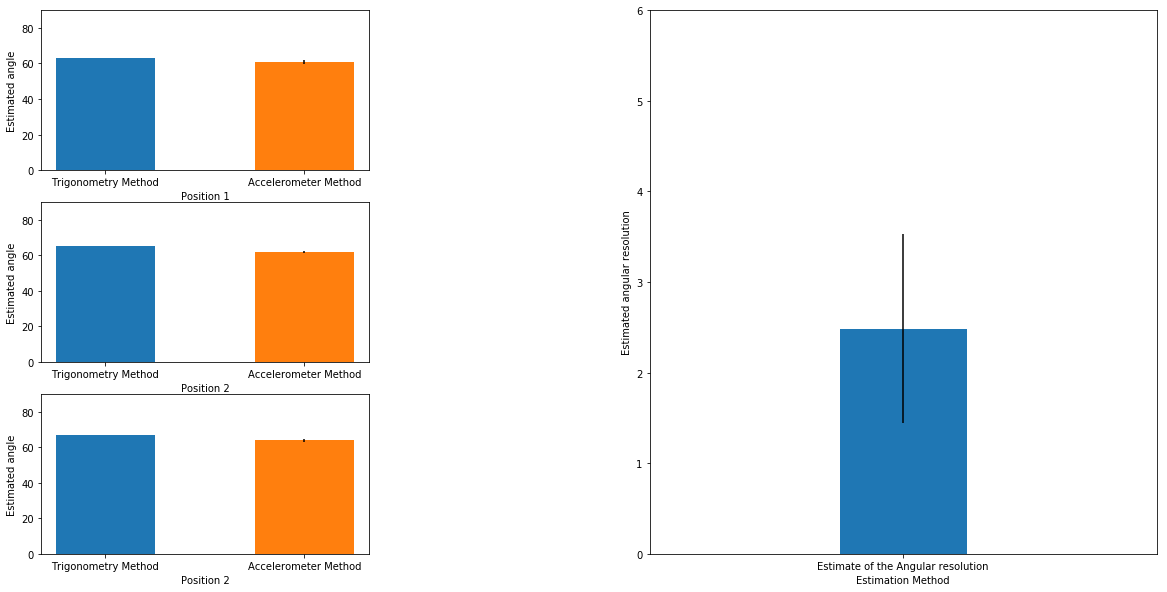

In [44]:



# Make figure with subplot, change figsize if your figure is too small/big
plt.figure(figsize=[20, 10])

# Position 1 subplot
plt.subplot(3, 3, 1)
plt.bar('Trigonometry Method', thetatrig1 , width=0.5) #thetatrig1 = 62.99
plt.bar('Accelerometer Method', meantheta1 , width=0.5, yerr=stdvtheta1) #meantheta1 = 60.86 and stdvtheta1 = 1.05
plt.ylim([0,90])
plt.xlabel('Position 1')
plt.ylabel('Estimated angle')

# Position 2 subplot
plt.subplot(3, 3, 4)
plt.bar('Trigonometry Method', thetatrig2 , width=0.5) #thetatrig2 = 65.4
plt.bar('Accelerometer Method', meantheta2 , width=0.5, yerr=stdvtheta2) #meantheta2 = 61.8 #stdvtheta2 = 0.659
plt.ylim([0,90]) 
plt.xlabel('Position 2')
plt.ylabel('Estimated angle')

# Position 3 subplot
plt.subplot(3, 3, 7)
plt.bar('Trigonometry Method', thetatrig3 , width=0.5) #thetatrig = 67.1
plt.bar('Accelerometer Method', meantheta3 , width=0.5, yerr=stdvtheta3) #meantheta3 = 63.86 #stdvtheta3 = 0.912
plt.ylim([0,90])
plt.xlabel('Position 2')
plt.ylabel('Estimated angle')

# Angular resolution subplot
plt.subplot(1, 2, 2)
plt.bar(0, meanresolution, width=0.5, yerr=stdvresolution, tick_label='Estimate of the Angular resolution') 
plt.xlim([-1, 1]) 
plt.ylim([0, 6])
plt.xlabel('Estimation Method')
plt.ylabel('Estimated angular resolution');

### Summary
The results of the experiment were satisfactory to a certain extent. The first part of the experiment which dealt with calculating the angle of inclination using the accelerometer gave relatively close results. The best result was from the first trial. The angles are the most similar and have a percentage difference between the two measurements is 3.38% which is relatively low. It was curious the angle calculated with the accelerometer always was lower than the angle calculated with trigonometry. My suspicion is that the accelerometer's lack of calibration had to do with this difference but other things in the method could've gone wrong as well. The angle calculated using trigonometry is more reliable because the method is simple and has less room for error. Two measurements were taken using a ruler and then used to calculate the angle. In the other hand, the angle calculations using the accelerometer has room for error during the data capturing and data processing which are two complicated actions. The accelerometer wasn't calibrated correctly at the start and many approximations were used to convert the initial readings of the teensy into Gs.  

For the second part of the experiment the results weren't as satisfactory. I used the best result which was the result of the first position to calculate the angular resolution.The estimated angular resolution was 2.48° which is a quite big resolution and the standard deviation of this results is quite big too. This is demonstrates that the accelerometer is not very accurate. However the method to calculate the angle resolution was not very accurate as it was hard to make the offset not overlap with the original results but at the same time be a close as possible to it. With a closer non-overlapping data set, a better angle resolution could've been achieved. 

## Appendix

### Source Code for Data Acquisition (include only main.py)

In [10]:
import microcontroller 
import board
import time
import digitalio
import storage
from analogio import AnalogIn
from neopixel import NeoPixel
from digitalio import DigitalInOut, Direction, Pull


neopixels = NeoPixel(board.D10, 1, brightness=0.05, auto_write=True)
neopixels.fill([0,255,0])
neopixels.brightness =0.1
button = DigitalInOut(board.D9)
button.pull = Pull.UP


def set_neopixel_color(color):
    if color == 'idle':
        neopixels.fill([255,165,0]) 
    if color == 'running':
        neopixels.fill([0,255,0]) 
    if color == 'error':
        neopixels.fill([255,0,0]) 




def write_file(time,sample,fp):
    fp.write('{0:.3f},{1:.4f}\n'.format(time,sample))

def write_file2(time,sample,fp):
    fp.write('{0:.3f},{1:.4f},{2:4f},{3:4f}\n'.format(time,sample[0],sample[1],sample[2]))
    
    

AnX = AnalogIn(board.A3)
AnY = AnalogIn(board.A4) 
AnZ = AnalogIn(board.A5)

def acceleration_sampler():
        Acc =(round(((AnX.value/19859)-1.65)/0.44,4),round(((AnY.value/19859)-1.65)/0.44,4),round(((AnZ.value/19859)-1.65)/0.44,4))
        return Acc

A = acceleration_sampler()
print(A)

def take_measurements2(sampler,duration,dt,write):
    set_neopixel_color('running')
    if write is True:
        fp = open("/Offset1.txt","w")
    start_time = time.monotonic()
    current_time = 0
    while current_time - start_time < duration:    
        current_time = time.monotonic()
        A = sampler() #microcontroller.cpu.temperature 
        print((current_time-start_time,A))
        if write is True:
            try:
                write_file2(current_time-start_time,A,fp)
            except:
                set_neopixel_color('error')
        time.sleep(dt)
        #if time_passed < dt:
         #   time.sleep(dt-time_passed)
         
    if write is True:
        fp.flush()
        fp.close()


while True:    
    set_neopixel_color('idle')
    if button.value == False:
        take_measurements2(acceleration_sampler,15,1/100,True)